<a href="https://colab.research.google.com/github/BDouchet/ML-concepts/blob/main/NN/Spotify_RapFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# setup

In [ ]:
!pip -q install spotipy 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials
cid ="abacd883ec6c485ab06f1a3f7d34c8b3"
secret = "6998a332313b44e3b0d4a4f8c56b074b" 
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Extract Track ids

Extraction of tracks using playlist of French Rap

In [3]:
track_results = sp.playlist_items('4l1CEhc7ZPbaEtiPdCSGbl',market='FR')['items']
ids=np.array([track_results[i]['track']['id'] for i in range(len(track_results))])
ids.shape

(65,)

In [4]:
track_results = sp.playlist_items('4l1CEhc7ZPbaEtiPdCSGbl',market='FR')['items']
ids=np.array([track_results[i]['track']['id'] for i in range(len(track_results))])

track_results = sp.playlist_items('1vJRCYfOpwM5LuVCrZpa1K',market='FR')['items']
ids=np.union1d(ids,
               np.array([track_results[i]['track']['id'] for i in range(len(track_results))]))

track_results = sp.playlist_items('37i9dQZF1DX4sJFeoGlF41',market='FR')['items']
ids=np.union1d(ids,
               np.array([track_results[i]['track']['id'] for i in range(len(track_results))]))

for i in range(0,5000,100):
    playlists=['2dRYCqtniv09ode7AL2zUL','5JEWr5PlRJT3uNz2EGaOOg','6zKwcm0z8d497vZ28XUYLk',
               '3WgEbuy7GjWU59HrZgbvmH','3VqLwOGLhgfaNie8rjHsXr','1WjJfuZdirquASaZPJ8ZzX']
    
    for playlist in playlists:
    
        track_results = sp.playlist_items(playlist,limit=100,market='FR',offset=i)['items']
        new_ids=np.array([track_results[i]['track']['id'] for i in range(len(track_results))])
        ids=np.union1d(ids,new_ids)


ids.shape

(2346,)

We want to predict the popularity of the tracks from a specified album. Here, it is the new songs of QALF Infinity.

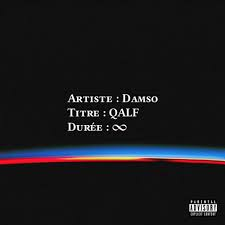

In [5]:
qalf_infinity=sp.album_tracks('2Cv2mrKMRyYuXJTlQmY4hj',market='FR')['items']
qalf_ids=np.array([qalf_infinity[i]['id'] for i in range(len(qalf_infinity))])

qalf=sp.album_tracks('62f3yVpi23o1YepGRLsSQI',market='FR')['items']
qalf_ids=np.union1d(qalf_ids,
                    np.array([qalf[i]['id'] for i in range(len(qalf))]))

qalf_ids.shape

(39,)

Take off the Albums songs from training dataset

In [6]:
ids_train=np.setdiff1d(ids,qalf_ids)
ids_train.shape

(2335,)

# Extract Audio Data 

Spotify provide access to specific data of the songs. We extract them in order to predict the popularity thanks to audio features. 

## Popularity & info

[Spotify](https://developer.spotify.com/documentation/web-api/reference/#objects-index) defined popularity as : 

*The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time*

So it's important to keep in mind that recent songs ususally have a higher popularity.

In [7]:
dataset=pd.DataFrame(ids_train,columns=['id'])
dataset[['name','popularity','album','artist']]=np.nan
dataset.set_index('id',inplace=True)

for i in range(0,len(ids_train),50):
    request=sp.tracks(ids_train[i:i+50],market='FR')['tracks']
    for req in request:
        dataset.loc[req['id']]=[req['name'],req['popularity'],
                        req['album']['name'],req['artists'][0]['name']]
dataset

,name,popularity,album,artist
id,,,,
00425NiwsF8LefyoOy8HB3,N26 (feat. Maes),54.0,TOXIC,Kaza
00LOYytr9EgGMAh4dEos8q,Ça sert - Live Session,25.0,Nemir,Nemir
00qC62jeyVSYuNISq9mGmK,Déstabilisé,51.0,Dans l'arène,Djadja & Dinaz
00s0HPhy1PXovEfmcDcEx6,Dubaï,52.0,"Freebase, Vol. 04",Kekra
00y6yHW6kv07HqWmodzjGb,SANG FROID,42.0,NOUVO MODE,Sneazzy
...,...,...,...,...
7zF8R12fP9fX4b11arc1FP,Cruel,66.0,Cruel,OBOY
7zQfWR8si2NiIffwC30thv,Chanson pour ton fils,17.0,Ça va bien s'passer,Flynt
7zcQ1j3vTLKWCkmPtO5rSR,Regarde le monde,42.0,Quelque chose a survécu,Ärsenik


Example of the Top 10 most popular songs in the dataset

In [8]:
dataset.sort_values('popularity',ascending=False).head(10)

,name,popularity,album,artist
id,,,,
6Vcxzw4ifKqYxVrp3ckpVF,HAINE&SEX,79.0,DRILL FR,Gazo
6sRPU30pj9A6G1pBXqzQkM,Vroum Vroum,77.0,Vroum Vroum,Moha K
5LYRIyhmlrDAQsYdHEvP0f,Mona Lisa,76.0,ULTRA,Booba
7qezIDRM0E3WTW1lWxItug,Mode Akimbo (feat. Jul),75.0,JVLIVS II,SCH
4CWcaGtaOyAqBDKIeZMUe0,La kiffance,75.0,La kiffance,Naps
03cOUvF1fyW60AuUfUNiDc,Mannschaft (feat. Freeze Corleone),74.0,JVLIVS II,SCH
7moGDROshDKDpuQxtQ3q4m,Champion,74.0,Champion,Serge Ibaka
3bGGvbwbhq9kIMhHaXBdYL,La danse des bandits,73.0,Les mains faites pour l'or,Naps
2vd2HEhrkafOi2uveHjzzh,La Seleçao,73.0,Capo Dei Capi Vol. II & III,Alonzo


List of represented artists

In [9]:
np.sort(dataset.artist.unique())

array(['100 Blaze', '113', '13 Block', '13 Organisé', '1PLIKÉ140', '2zer',
       '313', '404Billy', '47ter', '4Keus', '7 Jaws', '8ruki',
       '91 All Stars', 'A$tro Boi', 'A2h', 'ACHIM', 'ASHE 22',
       'Abd Al Malik', 'Abis', 'Ablv', 'Abouportant', 'Akhenaton',
       'Aladin 135', 'Alkpote', 'Allebou', 'Alonzo', 'Alpha Wann',
       'Ambre', 'Arma Jackson', 'Asakura', 'Ashkidd', 'Assy', 'Ateyaba',
       'Aya Nakamura', 'Azur', 'Aéro', 'B-DPE', 'BKL', 'BRVMSOO', 'BU$HI',
       'Barack Adama', 'Beerus La R', 'Bekar', 'Beneskyz', 'Beny',
       'Big B', 'Bigflo & Oli', 'Bilel', 'Binks Beatz', 'Blackawt',
       'Bola', 'Bolémvn', 'Booba', 'Bosh', 'Box', 'Bramsito', 'Brasco',
       'Brass', 'Brav', 'C.O.R', 'Caballero', 'Caballero & JeanJass',
       'Canardo', 'Captaine Roshi', 'Carbozo', 'Casseurs Flowters',
       'Casus Belli', 'Cheu-B', 'Chilla', 'Chiloo', 'Chily', 'Coelho',
       'Columbine', 'Coyote Jo Bastard', 'DA Uzi', 'DB', 'DECIMO',
       'DENZO', 'DJ Elite', 'DOXX'

Popularity Distribution

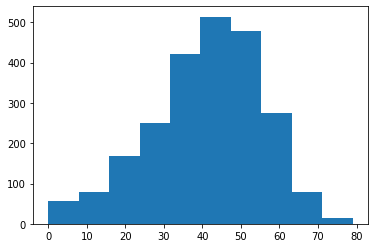

In [10]:
import matplotlib.pyplot as plt

plt.hist(dataset.popularity)
plt.show()

Same with Qalf Infinity, I took off dupliacted songs with previosu album QALF.

In [ ]:
# for QALF

qalf=pd.DataFrame(qalf_ids,columns=['id'])
qalf[['name','popularity','album','artist']]=np.nan
qalf.set_index('id',inplace=True)

request=sp.tracks(qalf_ids,market='FR')['tracks']

for req in request:
    qalf.loc[req['id']]=[req['name'],req['popularity'],
                            req['album']['name'],req['artists'][0]['name']]

qalf.sort_values('popularity',inplace=True,ascending=False)
qalf.drop_duplicates('name',inplace=True,keep=False)
qalf

,name,popularity,album,artist
id,,,,
0fukO3WYYUHaXOrvEohpEG,Σ. MOROSE,72.0,QALF infinity,Damso
2n3dCM1RqyhzH5FZQW4jxA,Π. VANTABLACK,71.0,QALF infinity,Damso
63ALxy05IGeKrfOjvGG7lO,Ο. OG,70.0,QALF infinity,Damso
3xkB3FONm2ZZKUpo5NRYGa,Τ. CHIALER,70.0,QALF infinity,Damso
1swQocGVyXMAamWDjNzoLx,Υ. 2 DIAMANTS,70.0,QALF infinity,Damso
0pU7enpfjSu21LwCb1708u,Ρ. DOSE,70.0,QALF infinity,Damso
7cg10lYnXMynfGg8K06rzL,Ψ. PASSION,69.0,QALF infinity,Damso
4URf8X1z0ZGaPemh0dKx2M,Φ. THEVIE RADIO,69.0,QALF infinity,Damso
2MH75OFe8QGguBKeh0esLj,Χ. ZWAAR,68.0,QALF infinity,Damso


## Audio features

12 features have been extracted : 

* **acousticness** : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

* **danceability** : Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable

* **duration_ms** : The duration of the track in milliseconds

* **energy** : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

* **key** : The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.

* **instrumentalness** : Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

* **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

* **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

* **mode** : Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

* **speechiness** : Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

* **tempo** : The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

* **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [ ]:
sp.audio_features(['1BhUyJoaS9iVvssrLx9oTD'])[0]

{'acousticness': 0.375,
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1BhUyJoaS9iVvssrLx9oTD',
 'danceability': 0.81,
 'duration_ms': 171496,
 'energy': 0.448,
 'id': '1BhUyJoaS9iVvssrLx9oTD',
 'instrumentalness': 6.04e-06,
 'key': 1,
 'liveness': 0.0906,
 'loudness': -13.029,
 'mode': 1,
 'speechiness': 0.253,
 'tempo': 97.996,
 'time_signature': 4,
 'track_href': 'https://api.spotify.com/v1/tracks/1BhUyJoaS9iVvssrLx9oTD',
 'type': 'audio_features',
 'uri': 'spotify:track:1BhUyJoaS9iVvssrLx9oTD',
 'valence': 0.528}

In [11]:
new_cols=['acousticness','danceability','duration_ms','energy',
         'instrumentalness','key','liveness','loudness','mode',
         'speechiness','tempo','valence']

dataset[new_cols]=np.nan

for i in range(0,len(dataset.index.to_list()),100):
    request=sp.audio_features(dataset.index.to_list()[i:i+100])
    for req in request:
        dataset.loc[req['id'],new_cols]=[req[col] for col in new_cols]

dataset

,name,popularity,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
id,,,,,,,,,,,,,,,,
00425NiwsF8LefyoOy8HB3,N26 (feat. Maes),54.0,TOXIC,Kaza,0.3410,0.639,185813.0,0.781,0.000037,2.0,0.1100,-7.259,0.0,0.0498,155.899,0.566
00LOYytr9EgGMAh4dEos8q,Ça sert - Live Session,25.0,Nemir,Nemir,0.9250,0.579,182008.0,0.203,0.000002,11.0,0.1330,-12.563,0.0,0.1080,108.978,0.423
00qC62jeyVSYuNISq9mGmK,Déstabilisé,51.0,Dans l'arène,Djadja & Dinaz,0.1250,0.763,256226.0,0.519,0.000000,1.0,0.1080,-7.431,1.0,0.0892,116.005,0.332
00s0HPhy1PXovEfmcDcEx6,Dubaï,52.0,"Freebase, Vol. 04",Kekra,0.2780,0.844,189833.0,0.733,0.000000,9.0,0.1240,-5.931,0.0,0.3340,129.985,0.411
00y6yHW6kv07HqWmodzjGb,SANG FROID,42.0,NOUVO MODE,Sneazzy,0.5360,0.841,184413.0,0.644,0.000003,10.0,0.0910,-5.882,1.0,0.2320,79.006,0.307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7zF8R12fP9fX4b11arc1FP,Cruel,66.0,Cruel,OBOY,0.3120,0.729,186461.0,0.491,0.000000,6.0,0.1010,-8.871,0.0,0.1680,141.886,0.594
7zQfWR8si2NiIffwC30thv,Chanson pour ton fils,17.0,Ça va bien s'passer,Flynt,0.8650,0.527,211187.0,0.157,0.021300,7.0,0.1130,-19.454,0.0,0.0684,130.157,0.186
7zcQ1j3vTLKWCkmPtO5rSR,Regarde le monde,42.0,Quelque chose a survécu,Ärsenik,0.0163,0.740,301667.0,0.809,0.000095,6.0,0.1070,-4.734,1.0,0.2170,92.065,0.524


In [ ]:
qalf[new_cols]=np.nan

request=sp.audio_features(qalf.index.to_list())

for req in request:
    qalf.loc[req['id'],new_cols]=[req[col] for col in new_cols]
qalf

,name,popularity,album,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
id,,,,,,,,,,,,,,,,
0fukO3WYYUHaXOrvEohpEG,Σ. MOROSE,72.0,QALF infinity,Damso,0.3590,0.723,263577.0,0.604,0.001060,4.0,0.1010,-7.848,0.0,0.0515,149.942,0.2700
2n3dCM1RqyhzH5FZQW4jxA,Π. VANTABLACK,71.0,QALF infinity,Damso,0.1740,0.535,153707.0,0.633,0.000007,11.0,0.3580,-8.801,0.0,0.5930,77.048,0.3500
63ALxy05IGeKrfOjvGG7lO,Ο. OG,70.0,QALF infinity,Damso,0.7610,0.605,100584.0,0.445,0.469000,7.0,0.1010,-10.168,1.0,0.0436,121.964,0.0647
3xkB3FONm2ZZKUpo5NRYGa,Τ. CHIALER,70.0,QALF infinity,Damso,0.4520,0.786,228860.0,0.434,0.000060,7.0,0.1150,-10.827,0.0,0.1270,129.913,0.1450
1swQocGVyXMAamWDjNzoLx,Υ. 2 DIAMANTS,70.0,QALF infinity,Damso,0.0971,0.792,197591.0,0.485,0.000008,8.0,0.1280,-8.815,0.0,0.1220,130.129,0.3920
0pU7enpfjSu21LwCb1708u,Ρ. DOSE,70.0,QALF infinity,Damso,0.3500,0.814,190617.0,0.594,0.000020,0.0,0.1040,-9.283,1.0,0.1750,135.991,0.4120
7cg10lYnXMynfGg8K06rzL,Ψ. PASSION,69.0,QALF infinity,Damso,0.1660,0.600,277108.0,0.499,0.000061,6.0,0.1200,-10.926,0.0,0.3830,144.330,0.5870
4URf8X1z0ZGaPemh0dKx2M,Φ. THEVIE RADIO,69.0,QALF infinity,Damso,0.1330,0.494,234528.0,0.457,0.000001,6.0,0.2620,-11.761,0.0,0.2190,131.883,0.2590
2MH75OFe8QGguBKeh0esLj,Χ. ZWAAR,68.0,QALF infinity,Damso,0.1150,0.595,201536.0,0.609,0.000011,11.0,0.1740,-8.773,0.0,0.3740,140.038,0.2740


# Data Preprocessing

* Standard Scaler
* Shuffling dataset
* Split Train Test

In [ ]:
df=dataset.copy()
qalff=qalf.copy()
df.drop(['name','album','artist'],inplace=True,axis=1)
qalff.drop(['name','album','artist'],inplace=True,axis=1)

stds=df.std()
means=df.mean()

df=(df-means)/stds
qalff=(qalff-means)/stds

X=df[df.columns[1:]].to_numpy()
Y=df.popularity.to_numpy()

X_app=qalff[qalff.columns[1:]].to_numpy()

print(X.shape,Y.shape,X_app.shape)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X,Y=shuffle(X,Y,random_state=42)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(1865, 12) (467, 12) (1865,) (467,)


# Simple Model

Basic ANN to demonstrate how Neural Networks work 

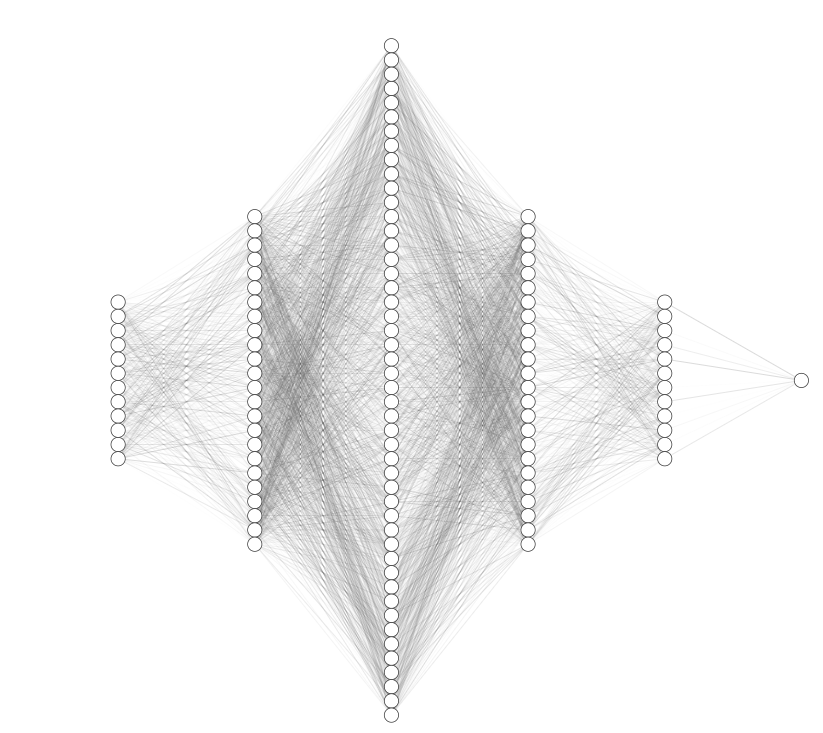

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
nn = models.Sequential()

nn.add(layers.Dense(24,activation='relu',input_shape=(12,)))
nn.add(layers.BatchNormalization())

nn.add(layers.Dense(48,activation='relu'))
nn.add(layers.BatchNormalization())
nn.add(layers.Dropout(0.5))

nn.add(layers.Dense(24,activation='relu'))
nn.add(layers.BatchNormalization())
nn.add(layers.Dropout(0.5))

nn.add(layers.Dense(12,activation='relu'))
nn.add(layers.BatchNormalization())
nn.add(layers.Dropout(0.5))

nn.add(layers.Dense(1,activation='tanh'))

#nn.summary()

In [ ]:
nn.compile(optimizer='adam',metrics=['mae'],loss='mse')
history=nn.fit(X_train,Y_train,epochs=75,validation_data=(X_test,Y_test),verbose=0)

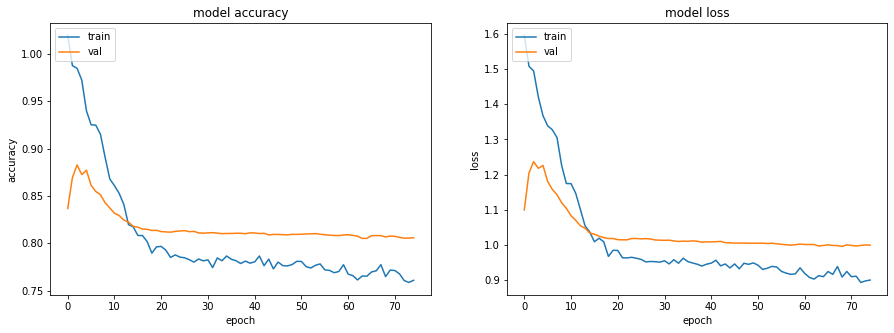

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history.history['mae'])
ax1.plot(history.history['val_mae'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

# Analysis

Predictions realised 01/05/21

In [ ]:
print('Training Precision : +/- {:.2f}'.format(nn.evaluate(X_train,Y_train,verbose=0)[1]*stds.popularity))
print('Testing Precision : +/- {:.2f}'.format(nn.evaluate(X_test,Y_test,verbose=0)[1]*stds.popularity))

Training Precision : +/- 10.83
Testing Precision : +/- 11.71


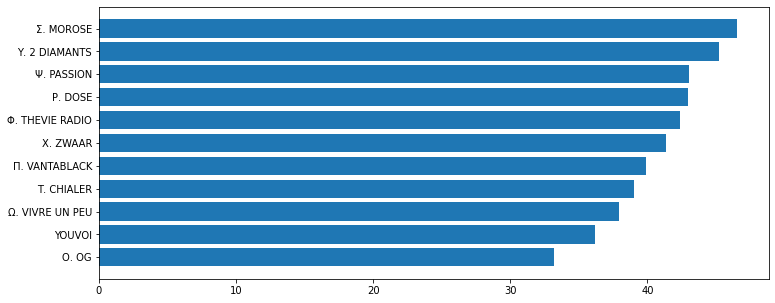

In [ ]:
Y_pred=nn.predict(X_app)

values=Y_pred*stds.popularity+means.popularity

out=qalf.loc[:,['name','popularity']]
out.loc[:,'pophat']=np.squeeze(values)
out.sort_values('pophat',inplace=True)

plt.figure(figsize=(12,5))

plt.barh(np.arange(len(qalf)),out.pophat.to_numpy())
plt.yticks(np.arange(len(qalf)),out.name.to_numpy())
plt.show()

Plays the 04/05/2021

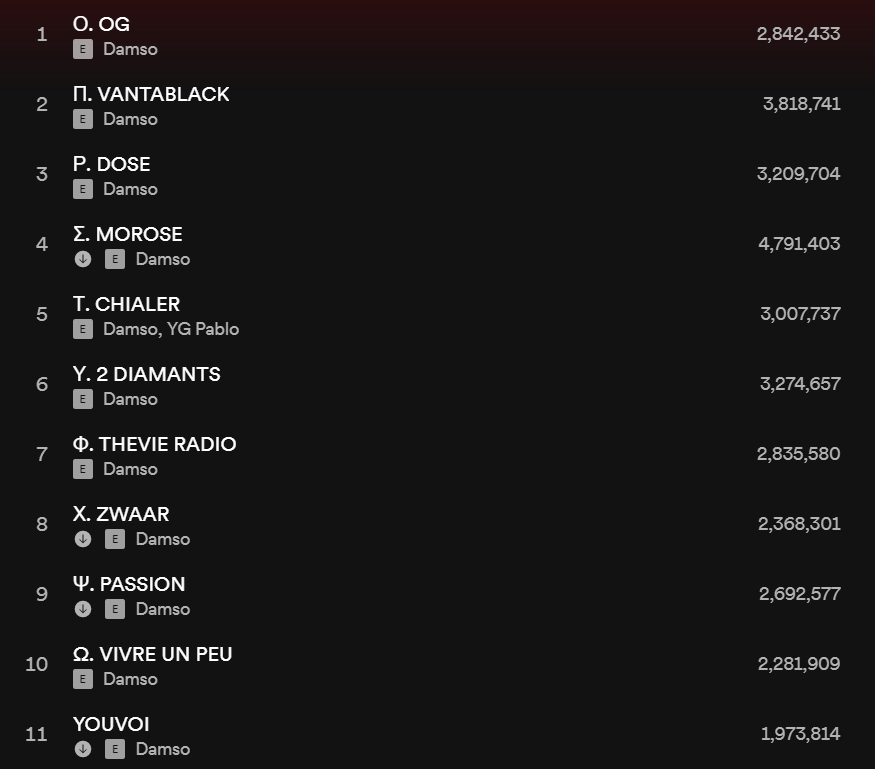

# Feature Analysis

## Correlation Matrix

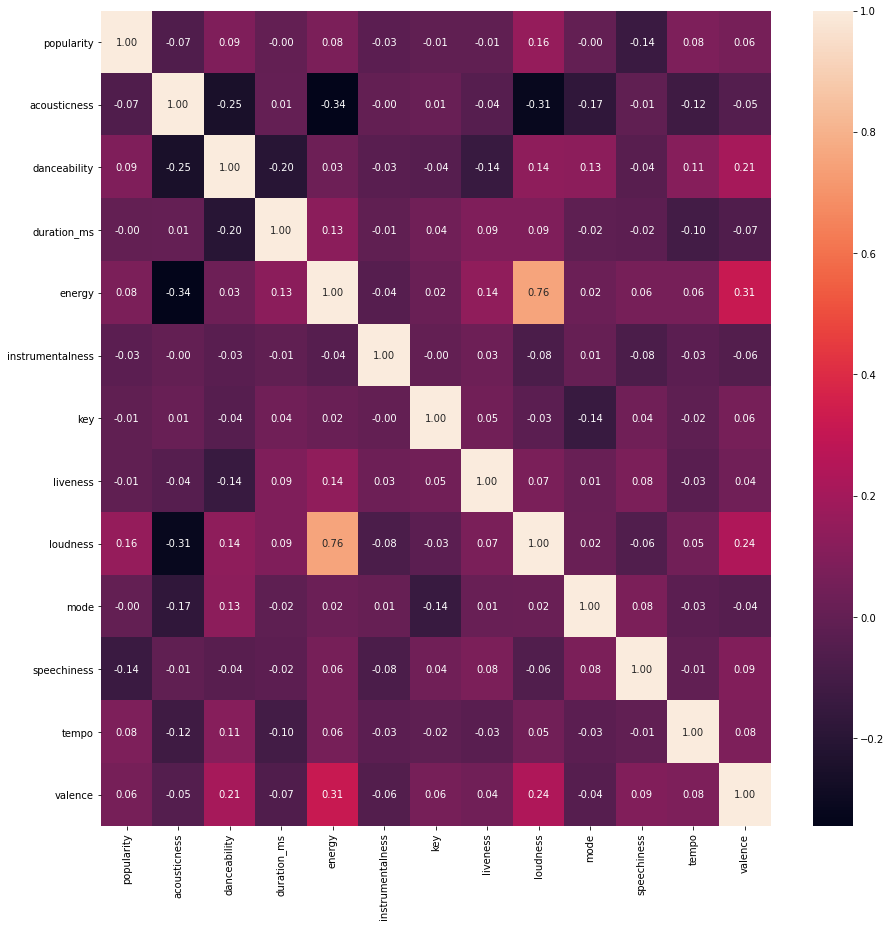

In [34]:
df_corr=df.corr()
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
sn.heatmap(df_corr,annot=True,fmt=".2f")
plt.show()

## With Trees Algorithmn

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score

dt=DecisionTreeRegressor()
rf=RandomForestRegressor()
gb=GradientBoostingRegressor()

dt.fit(X,Y)
rf.fit(X,Y)
gb.fit(X,Y)

print('Decision Tree : {:.2f}'.format(r2_score(Y,dt.predict(X))))
print('Random Forest : {:.2f}'.format(r2_score(Y,rf.predict(X))))
print('Gradient Boosting : {:.2f}'.format(r2_score(Y,gb.predict(X))))
print()
print('Baseline : {:.2f}'.format(r2_score(Y,np.array([Y.mean() for y in Y]))))


Decision Tree : 0.99
Random Forest : 0.86
Gradient Boosting : 0.31

Baseline : 0.00


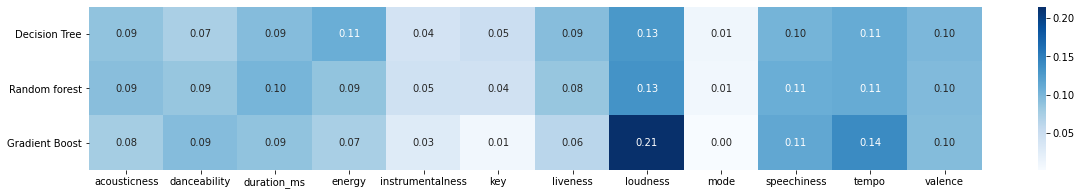

In [33]:
plt.figure(figsize=(20,3))
tab = pd.DataFrame(data=[dt.feature_importances_,rf.feature_importances_,gb.feature_importances_],
                   columns=df.columns[1:],
                   index=['Decision Tree','Random forest','Gradient Boost'])
sn.heatmap(tab,annot=True,fmt=".2f",cmap='Blues')
plt.show()